# Семантическая сегментация

### Задача 
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
<br>
Библиотеки: [Python, Tensorflow]

### Решение

In [17]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MY_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Computer_vision/Models'

### Скачиваем датасет COCO и API для работы с ним

In [18]:
%%time
if not os.path.isdir('data'):
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

CPU times: user 61 µs, sys: 14 µs, total: 75 µs
Wall time: 48.4 µs


### Подготовка COCO API

In [ ]:
COCO_ROOT = 'data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Универсальный класс Dataset для сегментации

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, 4))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :4]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        self.sublist = sublist
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=13.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


### Параметры обучения

In [ ]:
TRAIN_BATCH_SIZE = 16
TRAIN_EPOCHS = 10
VAL_BATCH_SIZE = 16
INPUT_SIZE = 256

### Создаем итераторы

In [ ]:
train_ds = COCO_dataset_train.train_dataset(
    TRAIN_BATCH_SIZE, 
    TRAIN_EPOCHS, 
    INPUT_SIZE)

val_ds = COCO_dataset_val.val_dataset(
    VAL_BATCH_SIZE, 
    INPUT_SIZE)

### Строим модель ASPP (Atrous Spatial Pyramid Pooling)

In [ ]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

### Обучение

In [ ]:
model = ASPPNet()

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])   

In [15]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(
        MY_DRIVE_PATH, 
        'coco_wghts_loss{val_loss:.2f}_acc{val_accuracy:.2f}.hdf5'), 
    save_weights_only=True)

history = model.fit(
    train_ds,
    steps_per_epoch=len(COCO_dataset_train.img_list) // TRAIN_BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=len(COCO_dataset_val.img_list) // VAL_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    callbacks=[callback])

Epoch 1/10
4007/4007 [==============================] - 1714s 428ms/step - loss: 0.4025 - accuracy: 0.8153 - val_loss: 0.3519 - val_accuracy: 0.8360
Epoch 2/10
4007/4007 [==============================] - 1693s 422ms/step - loss: 0.3069 - accuracy: 0.8602 - val_loss: 0.3295 - val_accuracy: 0.8528
Epoch 3/10
4007/4007 [==============================] - 1642s 410ms/step - loss: 0.2752 - accuracy: 0.8775 - val_loss: 0.2732 - val_accuracy: 0.8783
Epoch 4/10
4007/4007 [==============================] - 1633s 408ms/step - loss: 0.2548 - accuracy: 0.8883 - val_loss: 0.2597 - val_accuracy: 0.8870
Epoch 5/10
4007/4007 [==============================] - 1634s 408ms/step - loss: 0.2421 - accuracy: 0.8948 - val_loss: 0.2503 - val_accuracy: 0.8911
Epoch 6/10
4007/4007 [==============================] - 1629s 407ms/step - loss: 0.2298 - accuracy: 0.9016 - val_loss: 0.2551 - val_accuracy: 0.8921
Epoch 7/10
4007/4007 [==============================] - 1625s 406ms/step - loss: 0.2219 - accuracy: 0.9055

### Графики обучения

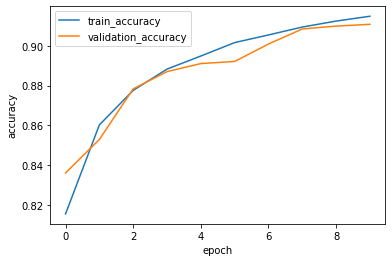

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

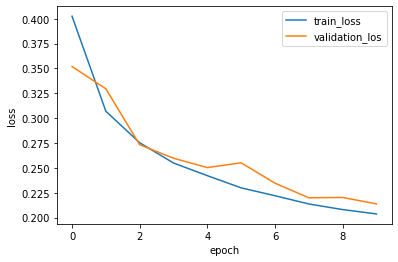

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_los'], loc='best')
plt.show()

##Запуск предсказания на нашем изображении

Скачаем изображение с человеком и проверим на ней работу модели

In [105]:
# !wget -O harold.jpg https://i.imgur.com/wmlkCseh.jpg

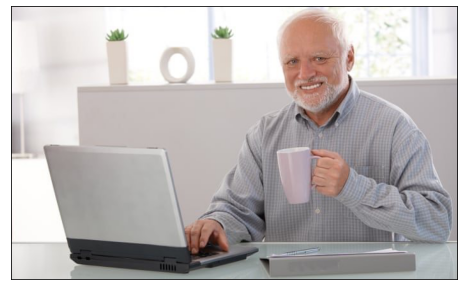

In [101]:
TEST_IMAGE = 'harold.jpg'

img = plt.imread(TEST_IMAGE).astype(np.float32) / 255

fig = plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.savefig(os.path.join(MY_DRIVE_PATH, 'harold.png'))
plt.show()

### Результат сегментации

In [102]:
preds = model([img])[0]

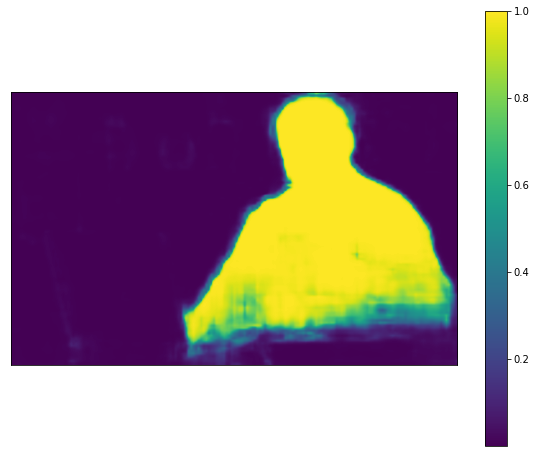

In [103]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(preds[..., 0])
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.savefig(os.path.join(MY_DRIVE_PATH, 'heatmap.png'))
plt.show()

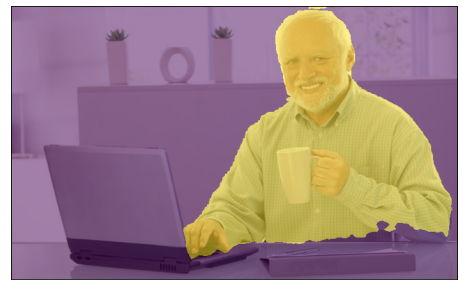

In [104]:
seg_map = np.float32(preds[..., 0] > 0.5)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]

fig = plt.figure(figsize=(8, 8))
plt.imshow(img * 0.5 + seg_map_clr * 0.5)
plt.xticks([]), plt.yticks([])
plt.savefig(os.path.join(MY_DRIVE_PATH, 'segmentation.png'))
plt.show()